In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.transforms as transforms
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [10]:
import sys
import os.path
# Local Modules
sys.path.insert(0, os.path.abspath('/scratch/horta/coronatwitter/'))
from helpers.plot import set_size, colors_cats
from helpers.vars import categories_final, lang_names

In [11]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

fontpath = os.path.expanduser('/dlabdata1/Roboto-Thin.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",#prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

Loads annotated timelines with keywords

Filter the tweets to keep only:

1. original tweets;
2. tweets from users whose timelines are not incomplete;
3. and tweets tweeted in 2020;

This yields ~11.4M tweets

In [12]:
imagepath = '/scratch/horta/coronatwitter/images/'

In [13]:
path = "/dlabdata1/gligoric/Coronatwitter/"
df_merged = pd.read_pickle(path + 'df_merged_timelines_twint_entriched.pickle')
df_merged['tweet_date'] = pd.to_datetime(df_merged['tweet_date'], utc=True)
df_merged = df_merged.reset_index()
df_merged = (df_merged[~df_merged['tweet_is_retweet']])
df_merged = (df_merged[~df_merged['incomplete_timeline']])
df_merged = df_merged[df_merged.tweet_date.dt.year > 2019]

In [14]:
df_weights = pd.read_pickle('/dlabdata1/gligoric/Coronatwitter/user_w.pkl')

In [15]:
df_all_covid_tweets = df_merged.merge(df_weights, left_on='user_id', right_on='user.screen_name')
df_all_covid_tweets.dropna(subset=["w"], inplace=True)

## FIG 1A

First we get a bunch of statistics for the accounts

In [16]:
def get_statistics(df, calculate_macro_avg=True, groupby_day=True, forbidden_cats=["Other"]):
    
    def helper_macro_avg(arr, w, arr_mean, arr_sem):
        arr = np.array(arr)
        mean, sem = weigthed_mean_sem(arr, w)
        arr_mean.append(mean)
        arr_sem.append(sem)
    
    def weigthed_mean_sem(arr, w):
        average = np.average(arr, weights=w)
        variance = np.average((arr - average)**2, weights=w)
        sem = np.sqrt(variance)/np.sqrt(len(arr))
        return average, sem
        
    vec_total_eng = [] # number of retweets + "favotites"
    vec_sum_all_tweets = [] # number of tweets
    vec_overall_ratio = [] # (number of retweets + "favotites") / number of tweets
    vec_fraction_covid = [] # number of covid tweets / number of tweets
    
    vec_total_eng_macroaverage = []
    vec_sum_all_tweets_macroaverage = []
    vec_overall_ratio_macroaverage = []
    vec_fraction_covid_macroaverage = []
    
    vec_total_eng_errors = []
    vec_sum_all_tweets_errors = []
    vec_overall_ratio_errors = []
    vec_fraction_covid_errors = []

    categories = []
    all_dates = [] # dates grouped by day

    for name, group in df.groupby("estimated_coarse_majority_category"):
        if name not in forbidden_cats:
            print(name)

            dates = []
            total_engagement = []
            sum_all_tweets = []
            overall_ratio = []
            fraction_covid = []

            mavg_total_engagement = [] 
            mavg_sum_all_tweets = []   
            mavg_overall_ratio = []    
            mavg_fraction_covid = []   

            err_total_engagement = [] 
            err_sum_all_tweets = []   
            err_overall_ratio = []    
            err_fraction_covid = []   

            # Iterates according to a group defined by falg
            if groupby_day:
                groupby_dir = [group.tweet_date.dt.year, group.tweet_date.dt.month, group.tweet_date.dt.day]
            else:
                groupby_dir = [pd.Grouper(key='tweet_date', freq='W-MON')]

            for date, gr in group[
                (~group['incomplete_timeline']) & \
                ([x.year if x.year>2019 else False for x in group['tweet_date']]) & \
                ([x.month if x.month<6 else False for x in group ['tweet_date']])
                ].groupby(groupby_dir):

                dates.append(date)

                tmp_w_sum = gr['w'].sum()
                total_engagement.append((gr['n_retweets_x'] * gr['w']).sum() + (gr['n_favotites'] * gr['w']).sum())
                sum_all_tweets.append(tmp_w_sum)                
                overall_ratio.append(np.average(gr['n_retweets_x'] + gr['n_favotites'], weights=gr['w']))
                fraction_covid.append((gr['is_covid'] * gr["w"]).sum()/tmp_w_sum)

                if calculate_macro_avg:
                    macro_avg_total_eng = []
                    macro_avg_sum_all_tweets = []
                    macro_overall_ratio = []
                    macro_fraction_covid = []
                    weigths_user = []

                    for user, user_gr in gr.groupby('user_id'):
                        weigths_user.append(user_gr['w'].mean())

                        macro_avg_total_eng.append((user_gr['n_retweets_x'].sum() + user_gr['n_favotites'].sum()))
                        macro_avg_sum_all_tweets.append(len(user_gr))
                        macro_overall_ratio.append(
                            (user_gr['n_retweets_x'].sum() + user_gr['n_favotites'].sum())/len(user_gr))
                        macro_fraction_covid.append(user_gr['is_covid'].mean())

                    weigths_user = np.array(weigths_user)

                    helper_macro_avg(macro_avg_total_eng, weigths_user, 
                                     mavg_total_engagement, err_total_engagement)
                    
                    helper_macro_avg(macro_avg_sum_all_tweets, weigths_user, 
                                     mavg_sum_all_tweets, err_sum_all_tweets)
                    
                    #we calculate average number of tweets posted in a day by a user
                    #this multiplied by the number of users is the final number of tweets
                    mavg_sum_all_tweets[-1] = mavg_sum_all_tweets[-1]*len(gr.groupby('user_id'))
                    
                    helper_macro_avg(macro_overall_ratio, weigths_user, 
                                     mavg_overall_ratio, err_overall_ratio)
                    helper_macro_avg(macro_fraction_covid, weigths_user, 
                                     mavg_fraction_covid, err_fraction_covid)

            all_dates.append(dates)
            categories.append(name)

            vec_total_eng.append(total_engagement)
            vec_sum_all_tweets.append(sum_all_tweets)
            vec_overall_ratio.append(overall_ratio)
            vec_fraction_covid.append(fraction_covid)

            vec_total_eng_macroaverage.append(mavg_total_engagement)
            vec_sum_all_tweets_macroaverage.append(mavg_sum_all_tweets)
            vec_fraction_covid_macroaverage.append(mavg_fraction_covid)
            vec_overall_ratio_macroaverage.append(mavg_overall_ratio)

            vec_total_eng_errors.append(err_total_engagement)
            vec_sum_all_tweets_errors.append(err_sum_all_tweets)
            vec_fraction_covid_errors.append(err_fraction_covid)
            vec_overall_ratio_errors.append(err_overall_ratio)

    return {"dates": np.array([pd.Timestamp(year=d[0], month=d[1], day=d[2]).to_datetime64()
                               if type(d) is not pd.Timestamp else
                               d.to_datetime64()
                               for d in all_dates[0]]), 
            "categories": categories,
            "total_eng": vec_total_eng, 
            "sum_all_tweets": vec_sum_all_tweets, 
            "overall_ratio": vec_overall_ratio, 
            "fraction_covid": vec_fraction_covid,
            "total_eng_macro": vec_total_eng_macroaverage, 
            "sum_all_tweets_macro": vec_sum_all_tweets_macroaverage, 
            "overall_ratio_macro": vec_overall_ratio_macroaverage, 
            "fraction_covid_macro": vec_fraction_covid_macroaverage,
            "total_eng_sem": vec_total_eng_errors, 
            "sum_all_tweets_sem": vec_sum_all_tweets_errors, 
            "overall_ratio_sem": vec_overall_ratio_errors, 
            "fraction_covid_sem": vec_fraction_covid_errors}

In [17]:
results_daily_macro = get_statistics(df_all_covid_tweets, calculate_macro_avg=True, forbidden_cats=[])

Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


Gets the covid fraction peaks

In [62]:
def plot_categories_timeseries_moving_avg(value, name, categories, categories_sorted):

    fig, axs = plt.subplots(figsize=(10,6))
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)

    for i, category in enumerate(categories_sorted):
        cnt = categories.index(category)
        s = pd.Series(value[cnt])
        sm = s.rolling(7).mean()
        axs.plot(range(7,len(sm)),sm[7:], 
                 color= colors_cats[category],
                 alpha=1, 
                 label=categories_final[category], 
                 linestyle = '-')

        axs.plot(range(0,7),[sm[6]]*7, 
                 color= colors_cats[category],
                 alpha=1, 
                 linestyle = ':')

    axs.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    axs.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)

    axs.set_xticks([0, 31, 60, 91, 121, 151])
    axs.set_xticklabels(['2020-1-1', '2020-2-1', '2020-3-1', '2020-4-1', '2020-5-1', '2020-5-31'], 
               size=14)
    axs.set_ylim([0,0.25])
    axs.set_yticks([0,0.05,0.1,0.15,0.2,0.25])
    axs.set_yticklabels(["0\%","5\%","10\%","15\%","20\%","25\%"], 
               size=14)
    axs.set_ylabel('Average daily percentage of tweets about COVID-19', size=16)
    axs.set_xlabel('Date', size=18)
    
    axs.axvline((pd.to_datetime("6th May 2020") - pd.to_datetime("01-01-2020")).days,  ls=':', color="black") 
    axs.axvline((pd.to_datetime("12th May 2020") - pd.to_datetime("01-01-2020")).days, ls=":", color="black") 
    
    axs.fill_between([(pd.to_datetime("6th May 2020") - pd.to_datetime("01-01-2020")).days,
                      (pd.to_datetime("12th May 2020") - pd.to_datetime("01-01-2020")).days]
                     , y1=0, y2=10000, color="black", alpha=0.1)
    trans = transforms.blended_transform_factory(
            axs.transData, axs.transAxes)

    plt.text(7.5, 
             1.02, "baseline period",
             transform=trans, ha='center', size=12)


    axs.axvline(0,  ls=':', color="black") 
    axs.axvline(15,  ls=":", color="black") 
    axs.fill_between([0, 15]
                      , y1=0, y2=10000, color="green", alpha=0.1)
    trans = transforms.blended_transform_factory(
            axs.transData, axs.transAxes)

    plt.text((pd.to_datetime("9th May 2020") - pd.to_datetime("01-01-2020")).days, 
             1.02, "account sampling period",
             transform=trans, ha='center', size=12)

    plt.text(91.6, 
             1.075, "study period",
             transform=trans, ha='center', size=12)


    prop = dict(arrowstyle="->", lw=0.5, color="black",
                shrinkA=0,shrinkB=0)

    trans = transforms.blended_transform_factory(
            axs.transData, axs.transAxes)
    plt.annotate("", xy=(149, 1.085), 
                 xytext=(103.5, 1.085), 
                 arrowprops=prop, xycoords=trans)

    plt.annotate("", xy=(17, 1.085), 
                 xytext=(79.5, 1.085), 
                 arrowprops=prop, xycoords=trans)


    axs.legend(loc="upper left", bbox_to_anchor=(1,0.9))
    axs.set_xticklabels(["2020-1-1", "2020-2-1", "2020-3-1", "2020-4-1", "2020-5-1", "2020-6-1"])
    set_size(fig, (10, 6))
    fig.savefig(imagepath + '{}.pdf'.format(name),bbox_inches='tight')

In [65]:
# Print Peaks
peaks = []
for i in range(13):
    peaks.append(np.max(pd.Series(results_daily_macro["fraction_covid_macro"][i]).rolling(7).mean().max()))
l1, l2 = zip(*sorted(zip(peaks, results_daily_macro["categories"])))
for i in range(len(l2)):
    print(l2[i],str(l1[i])[:7])
    
# Print Peaks
peaks = []
for i in range(13):
    peaks.append(pd.Series(results_daily_macro["fraction_covid_macro"][i]).rolling(7).mean().values[-1])
l1, l2 = zip(*sorted(zip(peaks, results_daily_macro["categories"])))

categories_sorted = l2[::-1]

Porn 0.06056
Other 0.08528
Art 0.09763
Sport 0.11180
Religion 0.12077
Business 0.12410
Science 0.13264
Outspoken Political Supporter 0.13937
Healthcare 0.16701
Public Services 0.17276
Media 0.18292
Non-Governmental Organization 0.19175
Government and Politics 0.21225


In [66]:
categories_sorted

('Government and Politics',
 'Healthcare',
 'Public Services',
 'Non-Governmental Organization',
 'Media',
 'Science',
 'Outspoken Political Supporter',
 'Business',
 'Art',
 'Religion',
 'Sport',
 'Other',
 'Porn')

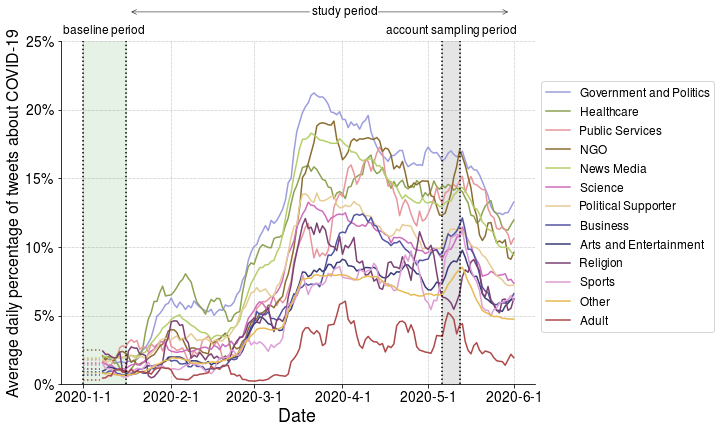

In [67]:
plot_categories_timeseries_moving_avg(results_daily_macro["fraction_covid_macro"], 
                                      '1A_fraction_covid_macro', results_daily_macro["categories"],
                                      categories_sorted)

## FIG 2A

In [22]:
results_weekly_macro = get_statistics(df_all_covid_tweets, groupby_day=False)

Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


In [23]:
categories_sorted = list(categories_sorted)
categories_sorted.remove("Other")

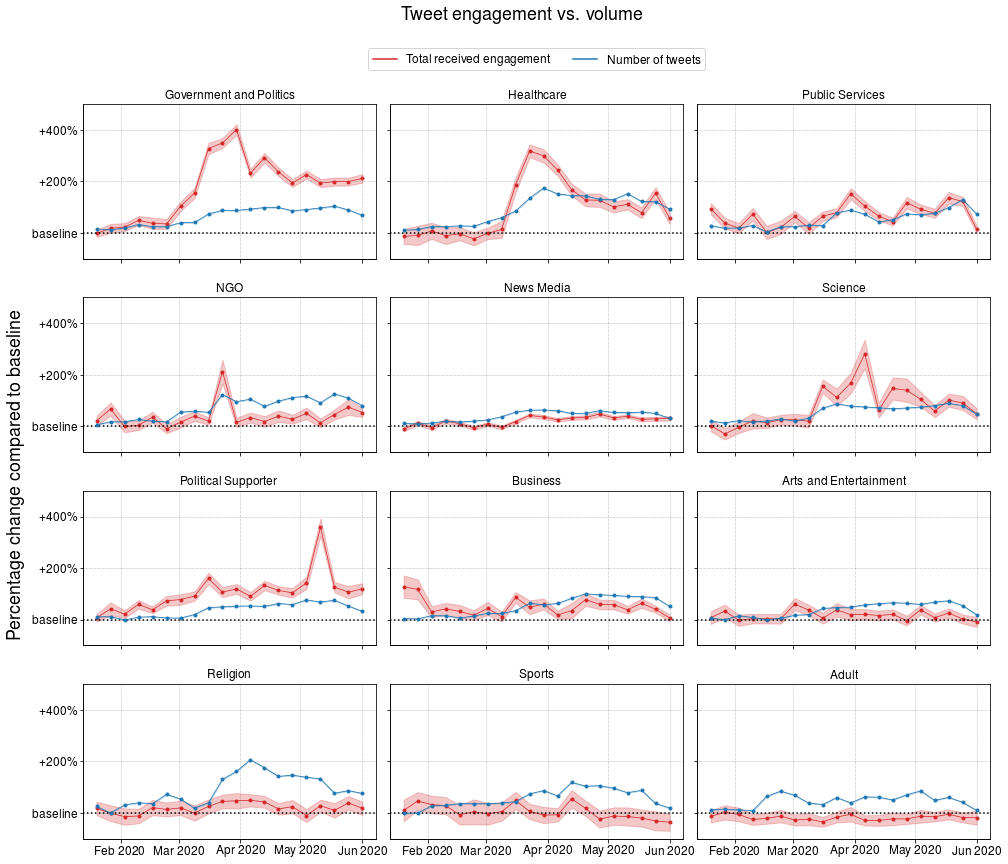

In [24]:
def helper_temporal(ax, results, line_val, err_val, dates_val, color, cnt, baseline_val):
    baseline = [np.mean(results[line_val][cnt][0:baseline_val])]
    observed = np.array(results[line_val][cnt][baseline_val:])
    error = np.array(results[err_val][cnt][baseline_val:])
    baseline = np.array(baseline * 100)[:len(observed)]
    percentage_change = (observed - baseline) / baseline
    error_baseline = error / observed
    ax.plot(results[dates_val][baseline_val:], percentage_change, color = color, lw=0.75)
    ax.scatter(results[dates_val][baseline_val:], percentage_change, color = color, marker=".")
    ax.fill_between(x=results[dates_val][baseline_val:], 
                    y1=percentage_change-error_baseline, y2=percentage_change+error_baseline, 
                    color = color, alpha=0.25)
    return percentage_change

fig, ax = plt.subplots(4,3, figsize = (14, 12), sharex = True, sharey=True, 
                       gridspec_kw={"hspace": 0.25, "wspace":0.05})
fig.suptitle("Tweet engagement vs. volume", size=18)
baseline_val = 2
max_ch = []
for i, category in enumerate(categories_sorted):
    cnt = results_weekly_macro["categories"].index(category)
    sbplt = ax[math.floor(i/3), i%3]
    ax2 = sbplt.twinx()

    
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    sbplt.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    sbplt.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    
    # plots stuff 
    
    percentage_change = helper_temporal(sbplt, results_weekly_macro, "total_eng_macro", "total_eng_sem", 
                    "dates", 'tab:red', cnt, baseline_val)
    helper_temporal(ax2, results_weekly_macro, "sum_all_tweets_macro", "sum_all_tweets_sem", 
                    "dates", 'tab:blue', cnt, baseline_val)
    
    sbplt.set_title(categories_final[results_weekly_macro["categories"][cnt]], size = 12)
    sbplt.set_yticks([0, 2, 4])
    sbplt.set_yticklabels(["baseline", r'+200\%', r'+400\%'])

    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b %Y')
    sbplt.xaxis.set_major_locator(months)
    sbplt.xaxis.set_major_formatter(months_fmt)
    sbplt.axhline(0, color = 'black', lw=1.5, ls=":")
    
    max_ch.append(np.mean(percentage_change))
    
    sbplt.set_ylim([-1,5])
    ax2.set_ylim([-1,5])
    ax2.set_yticks([])

fig.text(0.06, 0.5, 'Percentage change compared to baseline', va='center', rotation='vertical', size=18)

custom_lines = [Line2D([0], [0], color='tab:red'),
                Line2D([0], [0], color='tab:blue')]

ax[0, 1].legend(
    custom_lines, 
    ['Total received engagement', 'Number of tweets'],
    loc='upper center', 
    bbox_to_anchor=(0.5,1.4),
    ncol = 2
)

set_size(fig, (14, 12))
fig.savefig(imagepath + '/2A_timeseries_categories.pdf',bbox_inches='tight')

## FIG 2A Other

In [25]:
results_other = get_statistics(df_all_covid_tweets, groupby_day=False, forbidden_cats=categories_sorted)

Other


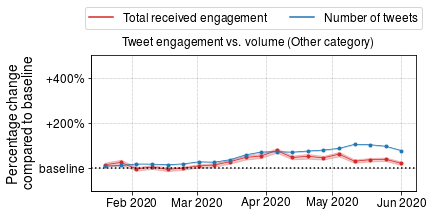

In [26]:
fig, ax = plt.subplots(1,1, figsize = (6, 3), sharex = True, sharey=True, gridspec_kw={"hspace": 0.5, "wspace":0.05})
fig.suptitle("Tweet engagement vs. volume (Other category)", size=12)
baseline_val = 2
max_ch = []

for i, category in enumerate(['Other']):
    cnt = results_other["categories"].index(category)
    sbplt = ax
    ax2 = sbplt.twinx()
    
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    sbplt.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    sbplt.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    
    # plots stuff 
    
    percentage_change = helper_temporal(sbplt, results_other, "total_eng_macro", "total_eng_sem", 
                    "dates", 'tab:red', cnt, baseline_val)
    helper_temporal(ax2, results_other, "sum_all_tweets_macro", "sum_all_tweets_sem", 
                    "dates", 'tab:blue', cnt, baseline_val)
    
    sbplt.set_yticks([0, 2, 4])
    sbplt.set_yticklabels(["baseline", r'+200\%', r'+400\%'])

    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b %Y')
    sbplt.xaxis.set_major_locator(months)
    sbplt.xaxis.set_major_formatter(months_fmt)
    sbplt.axhline(0, color = 'black', lw=1.5, ls=":")
    
    max_ch.append(np.mean(percentage_change))
    
    sbplt.set_ylim([-1,5])
    ax2.set_ylim([-1,5])
    ax2.set_yticks([])

    
sbplt.set_ylabel('Percentage change\ncompared to baseline', size=14)

custom_lines = [Line2D([0], [0], color='tab:red'), Line2D([0], [0], color='tab:blue')]

ax.legend(
    custom_lines, 
    ['Total received engagement', 'Number of tweets'],
    loc='upper center', 
    bbox_to_anchor=(0.5,1.4),
    ncol = 2
)

set_size(fig, (6, 3))
fig.savefig(imagepath + '/2A_other.pdf',bbox_inches='tight')

## FIG 2B

Government and Politics 2 0
Healthcare 3 1
Public Services 8 2
Non-Governmental Organization 5 3
Media 4 4
Science 10 5
Outspoken Political Supporter 6 6
Business 1 7
Art 0 8
Religion 9 9
Sport 11 10
Porn 7 11


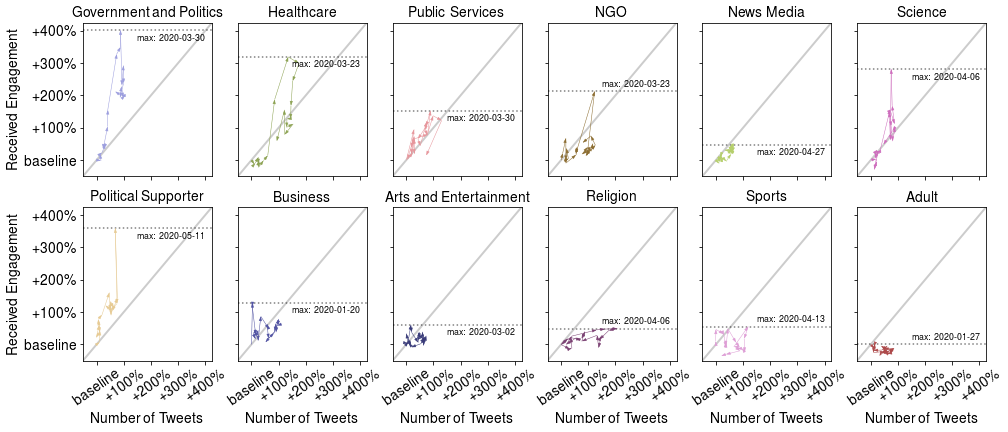

In [27]:
fig, axs = plt.subplots(2, 6, figsize = (14,6), sharey=True, sharex=True)
axs = axs.flatten()

def helper_arrows(val, baseline_val):
    baseline = [np.mean(val[0:baseline_val])]
    observed = np.array(val[baseline_val:])
    baseline = np.array(baseline * 100)[:len(observed)]
    percentage_change = (observed - baseline) / baseline
    return percentage_change
    

baseline_val = 2
for i, category in enumerate(categories_sorted):
    cnt = results_weekly_macro["categories"].index(category)
    print(category, cnt, i)
    ax = axs[i]

       
    val = results_weekly_macro["total_eng_macro"][cnt]
    change_eng =  helper_arrows(val, baseline_val)
    change_eng = np.concatenate([np.array([0]), change_eng])

    
    val = results_weekly_macro["sum_all_tweets_macro"][cnt]
    change_volume =  helper_arrows(val, baseline_val)
    change_volume = np.concatenate([np.array([0]), change_volume])

    eng = 0
    eng_j = 0
    
    dates_b = results_weekly_macro["dates"][baseline_val-1:]
    for j in range(1, len(change_eng)):

        prop = dict(arrowstyle="-|>,head_width=0.1,head_length=0.3", lw=0.5, 
                    color=colors_cats[category],
                    shrinkA=0,shrinkB=0)

        ax.annotate("", xy=(change_volume[j], change_eng[j]), 
                     xytext=(change_volume[j-1], change_eng[j-1]), 
                     arrowprops=prop, alpha=0.1)

        if change_eng[j] > eng:
            eng = change_eng[j]
            eng_j = j
            
    cats_top = ["Non-Governmental Organization", "Sport", "Porn", "Religion"]
            
    ax.annotate("max: {0}".format(str(dates_b[eng_j])[:10]), 
                xy=(change_volume[eng_j], change_eng[eng_j]), 
                xytext=(1.5, change_eng[eng_j] +(-0.3 if category not in cats_top else 0.15)), size=9, 
                ha="left")

    ax.axhline(change_eng[eng_j], ls=":", color="black", alpha=0.5)

    ax.set_title(categories_final[category])
    ax.plot([-10,10],[-10,10], lw=2, alpha=0.2, color="black")

ax = axs[0]
ax.set_xlim([-0.5, 4.25])
ax.set_ylim([-0.5, 4.25])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=0)
ax = axs[6]
ax.set_yticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=0)

    
axs[0].set_ylabel('Received Engagement', size=14)
axs[6].set_ylabel('Received Engagement', size=14)
for ax in axs[6:]:
    ax.set_xticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=35)

    ax.set_xlabel('Number of Tweets', size=14)

set_size(fig, (14, 6))
fig.savefig(imagepath + '/2B_paths.pdf',bbox_inches='tight')

## Fig 2B Other

Other 0 0


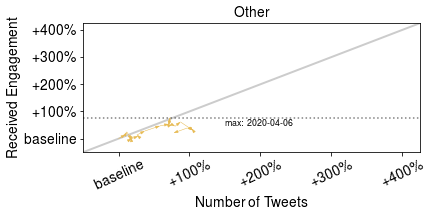

In [28]:
fig, axs = plt.subplots(1, 1, figsize = (6,3), sharey=True, sharex=True)
#axs = axs.flatten()

def helper_arrows(val, baseline_val):
    baseline = [np.mean(val[0:baseline_val])]
    observed = np.array(val[baseline_val:])
    baseline = np.array(baseline * 100)[:len(observed)]
    percentage_change = (observed - baseline) / baseline
    return percentage_change
    

baseline_val = 2
for i, category in enumerate(['Other']):
    cnt = results_other["categories"].index(category)
    print(category, cnt, i)
    ax = axs

       
    val = results_other["total_eng_macro"][cnt]
    change_eng =  helper_arrows(val, baseline_val)
    change_eng = np.concatenate([np.array([0]), change_eng])

    
    val = results_other["sum_all_tweets_macro"][cnt]
    change_volume =  helper_arrows(val, baseline_val)
    change_volume = np.concatenate([np.array([0]), change_volume])

    eng = 0
    eng_j = 0
    
    dates_b = results_weekly_macro["dates"][baseline_val:]
    for j in range(1, len(change_eng)):

        prop = dict(arrowstyle="-|>,head_width=0.1,head_length=0.3", lw=0.5, 
                    color=colors_cats[category],
                    shrinkA=0,shrinkB=0)

        ax.annotate("", xy=(change_volume[j], change_eng[j]), 
                     xytext=(change_volume[j-1], change_eng[j-1]), 
                     arrowprops=prop, alpha=0.1)

        if change_eng[j] > eng:
            eng = change_eng[j]
            eng_j = j
            
    cats_top = ["Non-Governmental Organization", "Sport", "Porn", "Religion"]
            
    ax.annotate("max: {0}".format(str(dates_b[eng_j-1])[:10]), 
                xy=(change_volume[eng_j], change_eng[eng_j]), 
                xytext=(1.5, change_eng[eng_j] +(-0.3 if category not in cats_top else 0.15)), size=9, 
                ha="left")

    ax.axhline(change_eng[eng_j], ls=":", color="black", alpha=0.5)

    ax.set_title(categories_final[category])
    ax.plot([-10,10],[-10,10], lw=2, alpha=0.2, color="black")

ax = axs
ax.set_xlim([-0.5, 4.25])
ax.set_ylim([-0.5, 4.25])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=0)
ax = axs
ax.set_yticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=0)

    
#axs.set_ylabel('Received Engagement', size=14)
axs.set_ylabel('Received Engagement', size=14)

ax.set_xticklabels(["baseline","+100\%","+200\%","+300\%","+400\%"], size=14, rotation=25)

ax.set_xlabel('Number of Tweets', size=14)

set_size(fig, (6, 3))
fig.savefig(imagepath + '/2B_paths_other.pdf',bbox_inches='tight')

## FIG 4A

In [29]:
results_weekly_macro_w_covid = get_statistics(df_all_covid_tweets.loc[df_all_covid_tweets['is_covid']], 
                                              groupby_day=False, forbidden_cats=[])

Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


In [30]:
results_weekly_macro_wo_covid = get_statistics(df_all_covid_tweets.loc[~df_all_covid_tweets['is_covid']], 
                                              groupby_day=False, forbidden_cats=[])

Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


Government and Politics
wcovid
[191.0723739   85.98687278  91.34064568 166.89211151 128.90151811
 146.10244179 136.15646052 218.57961298 276.77043614 244.44493455
 282.15842341 281.610545   433.09640989 319.35647472 352.87836065
 467.72347714 298.40351176 358.35943259 316.09170236 288.52537422
 266.88194873 294.95115486]
[154.28286898  70.2834318   74.54785252 135.23012649 104.02831523
 121.99632779 106.38411794 180.64705303 224.55508021 182.13461575
 217.76988343 228.95314613 347.16737802 254.72711363 262.55471159
 339.50219627 233.10973677 292.07492713 241.39405262 232.39752004
 206.02904349 217.27879695]
[227.86187882 101.69031376 108.13343884 198.55409653 153.77472099
 170.2085558  165.92880311 256.51217294 328.98579207 306.75525335
 346.5469634  334.26794388 519.02544175 383.98583581 443.2020097
 595.94475801 363.69728675 424.64393805 390.78935211 344.65322841
 327.73485398 372.62351278]
wocovid
[166.08499253 138.54624217 186.98829236 112.69853937 149.48710391
 173.24721888 158.39

Sport
wcovid
[ 198.2808814    63.54471779  109.25103069   41.15010913   40.74307101
  394.83820486  130.23472172  125.57183956  149.65798506  145.91938051
 2427.32001201  219.00190396  209.74841501  599.97263364  487.70075234
  123.55607125  268.99534001  326.54775877  642.01450064  328.06040146
  164.53960179  698.68404925]
[ 123.40522438   36.00292693   73.91560097   24.21979048   22.91150343
  245.23820181   99.38126551   85.46135476  115.17458775   81.54025583
 1429.42668301  129.01988407  117.89391868  229.41655927  329.05588375
   86.51358841  198.53548189  185.95454697  284.46793575  213.41039066
  104.74159071  439.53475013]
[ 273.15653842   91.08650865  144.58646042   58.08042777   58.57463858
  544.43820792  161.08817793  165.68232437  184.14138236  210.29850519
 3425.213341    308.98392385  301.60291134  970.52870801  646.34562094
  160.59855409  339.45519812  467.14097057  999.56106553  442.71041226
  224.33761287  957.83334837]
wocovid
[275.63074592 270.92551552 366.917260

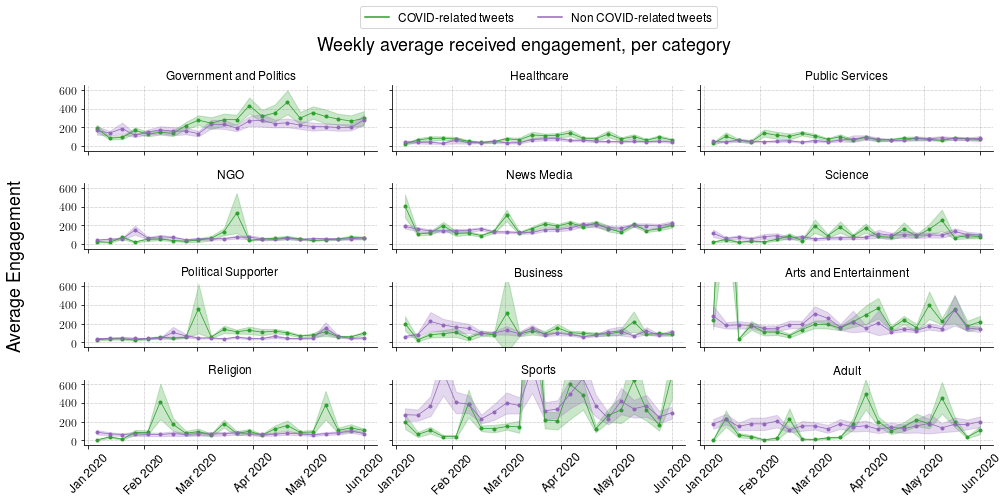

In [31]:
fig, ax = plt.subplots(4,3, figsize = (14, 7), sharex =True, sharey="row", 
                       gridspec_kw={"hspace": 0.5, "wspace":0.05})
fig.suptitle("Weekly average received engagement, per category", size=18)

def helper_temporal(ax, results, line_val, err_val, dates_val, color, cnt):
    err = np.array(results[err_val][cnt])
    ax.plot(results[dates_val], results[line_val][cnt], color = color, lw=0.75)
    print(np.array(results[line_val][cnt]))
    print(np.array(results[line_val][cnt])-err)
    print(np.array(results[line_val][cnt])+err)
    ax.scatter(results[dates_val], results[line_val][cnt], color = color, marker=".")
    ax.fill_between(x=results[dates_val], 
                    y1=np.array(results[line_val][cnt])-err, 
                    y2=np.array(results[line_val][cnt])+err, 
                    color = color, alpha=0.25)
    
def helper_temporal_baseline(ax, results, line_val, err_val, dates_val, color, cnt, baseline):
    err = np.array(results[err_val][cnt])
    ax.plot(results[dates_val][2:], (np.array(results[line_val][cnt])/baseline)[2:], color = color, lw=0.75)
    print(np.array(results[line_val][cnt]))
    print(np.array(results[line_val][cnt])-err)
    print(np.array(results[line_val][cnt])+err)
    ax.scatter(results[dates_val][2:], (np.array(results[line_val][cnt])/baseline)[2:], color = color, marker=".")
    ax.fill_between(x=results[dates_val][2:], 
                    y1=(np.array(results[line_val][cnt])-err)[2:]/baseline, 
                    y2=(np.array(results[line_val][cnt])+err)[2:]/baseline, 
                    color = color, alpha=0.25)
    
max_ch = []
for i, category in enumerate([cat for cat in categories_sorted if cat!='Other']):
    print(category)
    cnt = results_weekly_macro_w_covid["categories"].index(category)
    sbplt = ax[math.floor(i/3), i%3]
    
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    sbplt.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    sbplt.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    
    # plots stuff 
    baseline = np.mean(results_weekly_macro_wo_covid["overall_ratio_macro"][cnt][:2])
    
    print("wcovid")
    helper_temporal(sbplt, results_weekly_macro_w_covid, "overall_ratio_macro", "overall_ratio_sem", 
                    "dates", 'tab:green', cnt)#, baseline)
    print("wocovid")
    helper_temporal(sbplt, results_weekly_macro_wo_covid, "overall_ratio_macro", "overall_ratio_sem", 
                    "dates", 'tab:purple', cnt)#, baseline)
    
    sbplt.set_title(categories_final[category], size = 12)

    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b %Y')
    sbplt.xaxis.set_major_locator(months)
    sbplt.xaxis.set_major_formatter(months_fmt)
    
    max_ch.append(np.mean(percentage_change))
    
    sbplt.set_yticks([0, 200, 400, 600])
    sbplt.set_ylim([-50, 650])
#     sbplt.set_ylim([-1.5,6.5])
    plt.setp( sbplt.xaxis.get_majorticklabels(), rotation=45 )

fig.text(0.06, 0.5, 'Average Engagement', va='center', rotation='vertical', size=18)


ax[0, 1].legend(
    [Line2D([0], [0], color='tab:green'), Line2D([0], [0], color='tab:purple')], 
    ['COVID-related tweets', 'Non COVID-related tweets'],
    loc='upper center', 
    bbox_to_anchor=(0.5,2.3),
    ncol = 2
)

set_size(fig, (14, 7))
fig.savefig(imagepath + '4A_timeseries_covid.pdf',bbox_inches='tight')

## FIG  4A Other

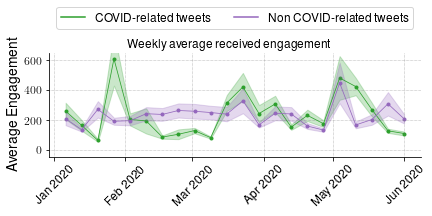

In [32]:
fig, ax = plt.subplots(1,1, figsize = (6, 3), sharex =True, sharey="row", 
                       gridspec_kw={"hspace": 0.5, "wspace":0.05})
fig.suptitle("Weekly average received engagement", size=12)

def helper_temporal(ax, results, line_val, err_val, dates_val, color, cnt):
    err = np.array(results[err_val][cnt])
    ax.plot(results[dates_val], results[line_val][cnt], color = color, lw=0.75)
    ax.scatter(results[dates_val], results[line_val][cnt], color = color, marker=".")
    ax.fill_between(x=results[dates_val], 
                    y1=np.array(results[line_val][cnt])-err, 
                    y2=np.array(results[line_val][cnt])+err, 
                    color = color, alpha=0.25)
    
max_ch = []
for i, category in enumerate(['Other']):

    cnt = results_weekly_macro_w_covid["categories"].index(category)
    sbplt = ax
    
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    sbplt.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    sbplt.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    
    # plots stuff 
    
    helper_temporal(sbplt, results_weekly_macro_w_covid, "overall_ratio_macro", "overall_ratio_sem", 
                    "dates", 'tab:green', cnt)
    helper_temporal(sbplt, results_weekly_macro_wo_covid, "overall_ratio_macro", "overall_ratio_sem", 
                    "dates", 'tab:purple', cnt)
    

    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b %Y')
    sbplt.xaxis.set_major_locator(months)
    sbplt.xaxis.set_major_formatter(months_fmt)
    
    max_ch.append(np.mean(percentage_change))
    
    sbplt.set_yticks([0, 200, 400, 600])
    sbplt.set_ylim([-50,650])
    plt.setp( sbplt.xaxis.get_majorticklabels(), rotation=45 )

sbplt.set_ylabel('Average Engagement', size=14)

ax.legend(
    [Line2D([0], [0], color='tab:green'), Line2D([0], [0], color='tab:purple')], 
    ['COVID-related tweets', 'Non COVID-related tweets'],
    loc='upper center', 
    bbox_to_anchor=(0.5,1.5),
    ncol = 2
)

set_size(fig, (6, 3))
fig.savefig(imagepath + '/4A_timeseries_covid_other.pdf',bbox_inches='tight')

## Fig S3

In [33]:
results_daily_macro_w_covid = get_statistics(df_all_covid_tweets.loc[df_all_covid_tweets['is_covid']])
results_daily_macro_wo_covid = get_statistics(df_all_covid_tweets.loc[~df_all_covid_tweets['is_covid']])

Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


In [34]:
list_entries = []

for i in range(12):
    for day in range(len(np.array(results_daily_macro_w_covid["dates"]))):
        try:
            entry_1 = {}
            entry_1["Category"] = results_daily_macro_w_covid["categories"][i]
            entry_1["Covid"] = 1
            entry_1["Average_engagement"] = results_daily_macro_w_covid["overall_ratio"][i][day]
            entry_2 = {}
            entry_2["Category"] = results_daily_macro_wo_covid["categories"][i]
            entry_2["Covid"] = 0
            entry_2["Average_engagement"] = results_daily_macro_wo_covid["overall_ratio"][i][day]
        except IndexError:
            #print(entry["Category"], day, i)
            continue
        
        list_entries.append(entry_1)
        list_entries.append(entry_2)

In [35]:
df_daily = pd.DataFrame(list_entries)
df_daily['standardized_average_engagement'] = ((df_daily['Average_engagement'] - df_daily['Average_engagement'].mean())/ \
                                df_daily['Average_engagement'].std())
df_daily['log_engagement'] = np.log1p(df_daily['Average_engagement'])

In [36]:
mod = smf.ols(formula="log_engagement ~ C(Covid)" +
                  "*C(Category,Treatment(reference='Outspoken Political Supporter'))",
              data=df_daily)
res = mod.fit(cov_type = 'HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_engagement   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     179.7
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        11:14:43   Log-Likelihood:                -4031.7
No. Observations:                3642   AIC:                             8111.
Df Residuals:                    3618   BIC:                             8260.
Df Model:                          23                                         
Covariance Type:                  HC0                                         
====================================================================================================================================================================================
                                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                            3.3671      0.032    105.890      0.000       3.305       3.429
C(Covid)[T.1]                                                                                                        0.1983      0.065      3.039      0.002       0.070       0.326
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Art]                                             1.4041      0.043     32.519      0.000       1.320       1.489
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Business]                                        0.5597      0.048     11.691      0.000       0.466       0.654
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Government and Politics]                         1.6800      0.044     37.855      0.000       1.593       1.767
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Healthcare]                                      0.5504      0.048     11.460      0.000       0.456       0.645
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Media]                                           1.1808      0.037     32.240      0.000       1.109       1.253
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Non-Governmental Organization]                   0.5268      0.045     11.797      0.000       0.439       0.614
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Porn]                                            0.5165      0.044     11.797      0.000       0.431       0.602
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Public Services]                                 0.5157      0.046     11.190      0.000       0.425       0.606
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Religion]                                        0.6656      0.043     15.349      0.000       0.581       0.751
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Science]                                         0.7488      0.049     15.306      0.000       0.653       0.845
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Sport]                                           1.5836      0.051     30.947      0.000       1.483       1.684
C(Covid)[T.1]:C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Art]                              -0.2090      0.101     -2.062      0.039      -0.408      -0.010
C(Covi

In [37]:
intercept = res.params['Intercept'] 


inter_values = []
inter_categories = []
inter_error = []

for variable in res.params.index:
    if "C(Category" in variable and 'ovid' in variable and 'language' not in variable and 'standardized_n_followers' not in variable:
        inter_categories.append(variable.split('.')[-1].strip(']'))
        inter_values.append(res.params[variable])
        inter_error.append(res.bse[variable])

default_category = "Outspoken Political Supporter"
default_coeff = res.params['C(Covid)[T.1]']

inter_categories.append(default_category)
inter_values.append(default_coeff)
inter_error.append(res.bse['C(Covid)[T.1]'])

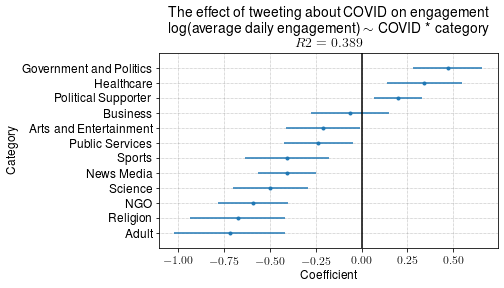

In [38]:
fig, ax = plt.subplots(figsize=(7,4))
l1, l2, l3= zip(*sorted(zip(inter_values,inter_categories, np.array(inter_error))))

ax.errorbar(np.array(l1), 
            np.array(range(len(l1))),
            xerr= 2*np.array(l3),
             linestyle = 'none',marker = 'o',markersize= 3)

ax.set_xlabel('Coefficient')
ax.set_ylabel('Category')
ax.set_yticks(range(len(l2)))
ax.set_yticklabels([categories_final[c] for c in l2])
ax.vlines(0,-1,len(l2))

ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)

ax.set_title('The effect of tweeting about COVID on engagement\n'
            'log(average daily engagement) $\sim$ COVID * category\n'
            '$R2=0.389$'
)

# ax.set_xlim([-1,1])
ax.set_ylim([-1,12])

set_size(fig, (7, 4))
fig.savefig(imagepath  + '/S2_regression_covid.pdf',bbox_inches='tight')

## Fig S4

In [39]:
list_entries = []

for lang, gr in df_all_covid_tweets.groupby('n_covid_tweeting_language'):
    
    print(lang)
    covid_vec_overall_ratio = []

    for name,group in gr.groupby("estimated_coarse_majority_category"):
        print(name)
        
        if name != 'Other':
            for date,gr_d in group[(~group['incomplete_timeline']) & \
                               ([x.year if x.year>2019 else False for x in group['tweet_date'] ]) & \
                               ([x.month if x.month<6 else False for x in group ['tweet_date'] ])
                              ].groupby([group.tweet_date.dt.year, 
                                         group.tweet_date.dt.month, 
                                         group.tweet_date.dt.day]):
                
                if len(gr_d.loc[gr_d['is_covid']]) > 0 and len(gr_d.loc[~gr_d['is_covid']]) > 0:
                    
                    entry = {}  
                    gr_temp = gr_d.loc[gr_d['is_covid']]
                    entry["Category"] = name
                    entry["Language"] = lang
                    entry["Covid"] = 1               
                    average = np.average(gr_temp['n_retweets_x'] + gr_temp['n_favotites'], weights=gr_temp['w'])
                    entry["Average_engagement"] = average
                    list_entries.append(entry)

                    entry = {}
                    gr_temp = gr_d.loc[~gr_d['is_covid']]
                    entry["Category"] = name
                    entry["Language"] = lang
                    entry["Covid"] = 0
                    average = np.average(gr_temp['n_retweets_x'] + gr_temp['n_favotites'], weights=gr_temp['w'])
                    entry["Average_engagement"] = average
                    list_entries.append(entry)

ar
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Public Services
Religion
Science
Sport
de
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
en
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
es
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
fr
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
it
Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport
ja


In [40]:
df_lang = pd.DataFrame(list_entries)
df_lang['standardized_average_engagement'] = (
        (df_lang['Average_engagement'] - df_lang['Average_engagement'].mean())/ df_lang['Average_engagement'].std())
df_lang['log_engagement'] = np.log1p(df_lang['Average_engagement'])

In [41]:
formula = "log_engagement ~ " \
          "C(Covid) * " \
          "C(Category,Treatment(reference='Outspoken Political Supporter')) * " \
          "C(Language, Treatment(reference='en'))"

mod = smf.ols(formula=formula,
              data=df_lang)

In [42]:
res = mod.fit(cov_type = 'HC0')

In [43]:
res.summary()

/scratch/horta/anaconda3/envs/overall/lib/python3.6/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 191, but rank is 189
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_engagement   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     284.3
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        11:16:31   Log-Likelihood:                -32345.
No. Observations:               23882   AIC:                         6.507e+04
Df Residuals:                   23692   BIC:                         6.660e+04
Df Model:                         189                                         
Covariance Type:                  HC0                                         
=================================================================================================================================================================================================================================
                                                                                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                         3.0940      0.038     81.805      0.000       3.020       3.168
C(Covid)[T.1]                                                                                                                                                     0.3124      0.074      4.251      0.000       0.168       0.457
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Art]                                                                                          1.2882      0.060     21.527      0.000       1.171       1.405
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Business]                                                                                     0.7302      0.064     11.450      0.000       0.605       0.855
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Government and Politics]                                                                      1.4409      0.053     27.012      0.000       1.336       1.545
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Healthcare]                                                                                   0.5749      0.065      8.828      0.000       0.447       0.703
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Media]                                                                                        1.3460      0.050     27.182      0.000       1.249       1.443
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Non-Governmental Organization]                                                                0.3812      0.058      6.556      0.000       0.267       0.495
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Porn]                                                                                         0.6831      0.052     13.016      0.000       0.580       0.786
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Public Services]                                                                              1.0245      0.062     16.510      0.000       0.903       1.146
C(Category, Treatment(reference='Outspoken Political Supporter'))[T.Religion]                                                                    

## Healthcare

In [44]:
intercept = res.params['Intercept']
inter_values = []
inter_categories = []
inter_error = []
for variable in res.params.index:
    if "C(Category" in variable and 'ovid' in variable and 'Language' in variable and 'Healthcare' in variable:
        inter_categories.append(variable.split('.')[-1].strip(']'))
        inter_values.append(res.params[variable])
        inter_error.append(res.bse[variable])
default_category = "en"
tmp = 'C(Covid)[T.1]:C(Category, Treatment(reference=\'Outspoken Political Supporter\'))[T.Healthcare]'
default_coeff = res.params[tmp]
inter_categories.append(default_category)
inter_values.append(default_coeff)
inter_error.append(res.bse[tmp])


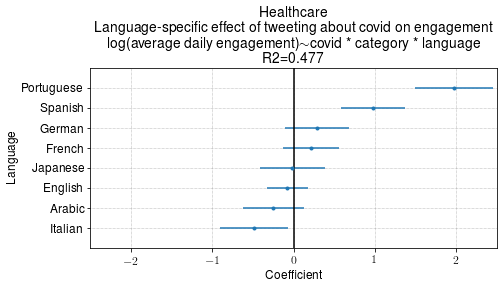

In [45]:
fig, ax = plt.subplots(figsize=(7, 4))

l1, l2, l3 = zip(*sorted(zip(inter_values, inter_categories, np.array(inter_error))))

ax.errorbar(np.array(l1), 
            np.array(range(len(l1))), 
            xerr=2 * np.array(l3), 
            linestyle='none', marker='o', 
            markersize=3)

ax.set_xlabel('Coefficient')
ax.set_ylabel('Language')
ax.set_yticks(range(len(l2)))
ax.set_yticklabels([lang_names[l] for l in l2])
ax.vlines(0, -1, len(l2))

ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)

ax.set_title("Healthcare\n"
             "Language-specific effect of tweeting about covid on engagement\n"
             r'log(average daily engagement)$\sim$'
             "covid * category * language\n" 
             'R2=0.477'
             )

ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-1, 8])

set_size(fig, (7, 4))
plt.savefig(imagepath + '/S5_regression_hc.pdf', bbox_inches='tight')

## Government and Politics

In [46]:
intercept = res.params['Intercept']
inter_values = []
inter_categories = []
inter_error = []
for variable in res.params.index:
    if "C(Category" in variable and 'ovid' in variable and 'Language' in variable and 'Politics' in variable:
        inter_categories.append(variable.split('.')[-1].strip(']'))
        inter_values.append(res.params[variable])
        inter_error.append(res.bse[variable])
default_category = "en"
tmp = 'C(Covid)[T.1]:C(Category, Treatment(reference=\'Outspoken Political Supporter\'))[T.Government and Politics]'
default_coeff = res.params[tmp]
inter_categories.append(default_category)
inter_values.append(default_coeff)
inter_error.append(res.bse[tmp])

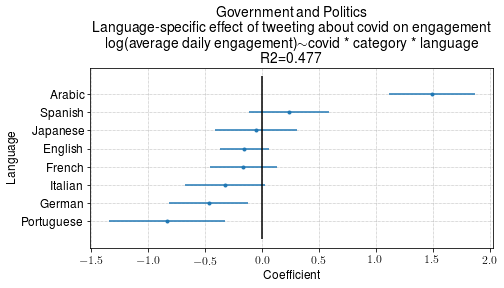

In [47]:
fig, ax = plt.subplots(figsize=(7, 4))

l1, l2, l3 = zip(*sorted(zip(inter_values, inter_categories, np.array(inter_error))))

ax.errorbar(np.array(l1),
            np.array(range(len(l1))),
            xerr=2 * np.array(l3),
            linestyle='none',
            marker='o',
            markersize=3)

ax.set_xlabel('Coefficient')
ax.set_ylabel('Language')
ax.set_yticks(range(len(l2)))
ax.set_yticklabels([lang_names[l] for l in l2])
ax.vlines(0, -1, len(l2))

ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)

ax.set_title("Government and Politics\n"
             "Language-specific effect of tweeting about covid on engagement\n"
             r'log(average daily engagement)$\sim$'
             "covid * category * language\n" 
             'R2=0.477'
             )

set_size(fig, (7, 4))
plt.savefig(imagepath + '/S5_regression_gvt.pdf', bbox_inches='tight')

# Fig 3

In [48]:
categories = results_daily_macro["categories"]
##select all baseline tweets
df_all_baseline_tweets = df_merged.loc[(df_merged["estimated_coarse_majority_category"].isin(categories)) &
                                   (~df_merged['incomplete_timeline']) & 
                                   ([x.year if x.year>2019 else False for x in df_merged['tweet_date'] ]) & \
                                   ([x.month if x.month<2 else False for x in df_merged['tweet_date'] ]) & \
                                    ([x.day if (x.day <= 15) else False for x in df_merged['tweet_date'] ])]

df_all_baseline_tweets.loc[:,'normalized_rank_engagement'] =\
    ((df_all_baseline_tweets['n_retweets_x'] + (df_all_baseline_tweets['n_favotites'] )).rank().values)\
    /np.max(((df_all_baseline_tweets['n_retweets_x'] + (df_all_baseline_tweets['n_favotites'] )).rank().values))
             
             
df_all_treated_tweets = df_merged.loc[(df_merged["estimated_coarse_majority_category"].isin(categories)) &
                               (~df_merged['incomplete_timeline']) & 
                               ([x.year if x.year>2019 else False for x in df_merged['tweet_date'] ]) & \
                               ([x.month if ~(x.month<2 and x.day<=15) else False for x in df_merged['tweet_date']])]
## find the average ranks of retweets 
df_all_treated_tweets.loc[:,'normalized_rank_engagement'] =\
    ((df_all_treated_tweets['n_retweets_x'] + (df_all_treated_tweets['n_favotites'] )).rank().values)\
    /np.max(((df_all_treated_tweets['n_retweets_x'] + (df_all_treated_tweets['n_favotites'] )).rank().values))
             

#join both dataframes with weights
df_all_baseline_tweets = df_all_baseline_tweets.merge(df_weights, left_on='user_id', right_on='user.screen_name')
df_all_baseline_tweets.dropna(subset=["w"], inplace=True)
df_all_treated_tweets = df_all_treated_tweets.merge(df_weights, left_on='user_id', right_on='user.screen_name')
df_all_treated_tweets.dropna(subset=["w"], inplace=True)
#group by user and find number of followers and weight of a user
df_users = df_all_treated_tweets.groupby('username_x').apply(lambda x: pd.Series({
            'n_covid_tweeting_language': x['n_covid_tweeting_language'].iloc[0],
            'n_followers': x['n_followers_y'].iloc[0],
            'estimated_coarse_majority_category': x['estimated_coarse_majority_category'].iloc[0],
            'weight': x['w'].iloc[0]
            }))
df_users = df_users.reset_index()
df_users.loc[:,'normalized_rank_followers'] =\
    (df_users['n_followers'].rank().values)/np.max((df_users['n_followers'].rank().values))
##check for total number of tweets in the studied period to determine the bubble size
marker_sizes_covid = {}
for lang in ['en', 'ar', 'es', 'de', 'fr', 'ja', 'it', 'pt']:
    sel_lang = df_all_treated_tweets[df_all_treated_tweets['n_covid_tweeting_language'] == lang]
    marker_sizes_covid[lang] = sel_lang['estimated_coarse_majority_category'].value_counts(normalize = True).to_dict()
#calculate weighted average ranks
x_b = []
for name, gr in df_all_baseline_tweets.groupby('estimated_coarse_majority_category'):
        x_b.append(( gr['w'] * (gr['normalized_rank_engagement'])).sum() /gr['w'].sum())
x_t = []
for name, gr in df_all_treated_tweets.groupby('estimated_coarse_majority_category'):
        x_t.append(( gr['w'] * (gr['normalized_rank_engagement'])).sum() /gr['w'].sum()) 

/scratch/horta/anaconda3/envs/overall/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/scratch/horta/anaconda3/envs/overall/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Art
Business
Government and Politics
Healthcare
Media
Non-Governmental Organization
Other
Outspoken Political Supporter
Porn
Public Services
Religion
Science
Sport


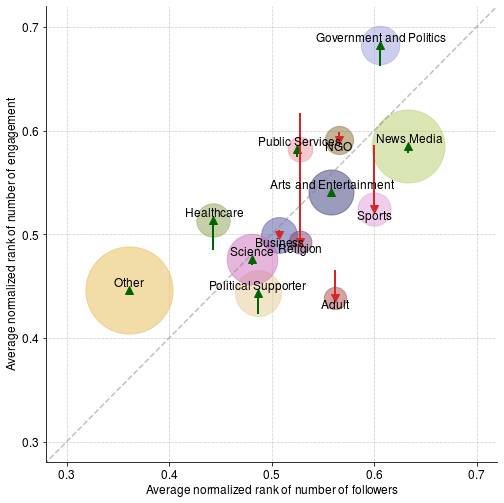

In [58]:
fig, axs = plt.subplots(figsize=(7, 7))

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
names = []
x = []
y = []
m_sizes = []
i = 0
for name, gr in df_users.groupby('estimated_coarse_majority_category'):
    print(name)

    x.append((gr['weight'] * (gr['normalized_rank_followers'])).sum() /gr['weight'].sum())

    
    plt.plot(x[-1],x_t[i],
             markersize = 20*np.log(20*sum([marker_sizes_covid[l][name] for l in ['en', 'ar', 'es', 'de', 'fr', 'ja', 'it', 'pt'] if name in marker_sizes_covid[l].keys()])+2),
                 color = colors_cats[name], linestyle = 'none',marker = 'o', alpha = 0.5)
    if x_b[i] < x_t[i]:
        if name == "Public Services":
            #shift the afrrow slightly to make it visible
            plt.plot([x[-1]-.003],[x_t[i]],marker = "^", color = 'darkgreen',markersize= 8)# alpha = 0.1+10*np.abs(x_t[i] - x_b[i]))
            plt.plot([x[-1]-.003,x[-1]-0.003],[x_t[i],x_b[i]], linewidth = 2, #alpha = 0.1+10*np.abs(x_t[i] - x_b[i]),
                     color = 'darkgreen')
        else:
                
            plt.plot([x[-1]],[x_t[i]],marker = "^", color = 'darkgreen',markersize= 8)# alpha = 0.1+10*np.abs(x_t[i] - x_b[i]))
            plt.plot([x[-1],x[-1]],[x_t[i],x_b[i]], linewidth = 2, #alpha = 0.1+10*np.abs(x_t[i] - x_b[i]),
                     color = 'darkgreen')
    else:
        plt.plot([x[-1]],[x_t[i]],marker = "v", color = 'tab:red',markersize= 8)
                 #alpha = 0.1+10*np.abs(x_t[i] - x_b[i]))
        plt.plot([x[-1],x[-1]],[x_t[i],x_b[i]], linewidth = 2,# alpha = 0.1+10*np.abs(x_t[i] - x_b[i]),
                 color = 'tab:red')
    i+=1
    names.append(name)


for i, txt in enumerate(names):
    if x_b[i] < x_t[i]:
        plt.annotate(categories_final[txt], (x[i], x_t[i] + 0.007), ha="center", va="center")
    else:
        plt.annotate(categories_final[txt], (x[i], x_t[i] - 0.007), ha="center", va="center")
        

axs.set_xlim([0.28,0.72])
axs.set_ylim([0.28,0.72])

from matplotlib import font_manager
sizeOfFont = 12
fontProperties = {'family':'sans-serif',
    'weight' : 'normal', 'size' : sizeOfFont}
ticks_font = font_manager.FontProperties(family='Helvetica', style='normal',
    size=sizeOfFont, weight='normal', stretch='normal')
from matplotlib.pyplot import gca
a = gca()
a.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7])
a.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
a.set_xticklabels(["0.3", "0.4", "0.5", "0.6", "0.7"], fontProperties)
a.set_yticklabels(["0.3", "0.4", "0.5", "0.6", "0.7"], fontProperties)


axs.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
axs.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)


axs.set_xlabel('Average normalized rank of number of followers')
axs.set_ylabel('Average normalized rank of number of engagement')
axs.plot([0,1],[0,1],color = 'gray', alpha = 0.5, linestyle = '--')
set_size(fig, (7, 7))
fig.savefig(imagepath + '3_followers.pdf',bbox_inches='tight')